In [1]:
from model.Season import Season

In [3]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm

In [22]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)

In [23]:
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017


In [6]:
men = []
ladies = []
pairs = []
dance = []
skaters = [men, ladies, pairs, dance]

In [7]:
for year in seasons:
    season = seasons[year]
    for event in season.events:
        for i, discipline in enumerate(event.disciplines):
            df = pd.read_csv(discipline.results_csv)
            skaters[i].append(df)

In [8]:
all_ladies = pd.concat(ladies)

In [9]:
all_ladies.Date = pd.to_datetime(all_ladies.Date)

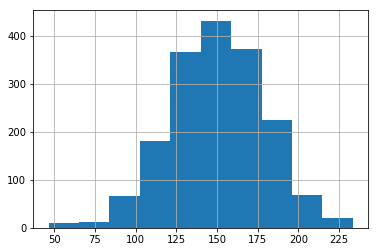

In [10]:
all_ladies[all_ladies['Free Rank'].str.isalpha() != True]['Points'].astype(float).hist()
plt.show()

In [14]:
completed = all_ladies[all_ladies['Free Rank'].str.isalpha() != True]

In [15]:
ladies_17 = pd.concat(ladies[-10:])

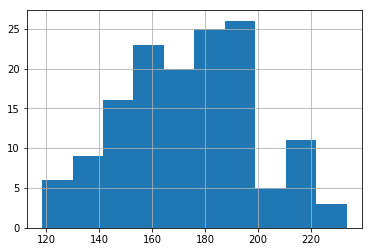

In [16]:
ladies_17[ladies_17['Free Rank'].str.isalpha() != True]['Points'].astype(float).hist()
plt.show()

In [11]:
def ascii_encode_dict(data):
    ascii_encode = lambda x: x.encode('ascii')
    return dict(map(ascii_encode, pair) for pair in data.items())

with open('pd_data/name_fixes_men.json') as f:
    men_name_fixes = f.read()
men_name_fixes = json.loads(men_name_fixes, object_hook=ascii_encode_dict)

In [12]:
all_men_results = pd.concat(men)

In [13]:
all_men_results.Date = pd.to_datetime(all_men_results['Date'])

In [14]:
for wrong_name, right_name in men_name_fixes.iteritems():
    all_men_results.loc[all_men_results.Name == wrong_name, 'Name'] = right_name

In [15]:
all_men_results = all_men_results[all_men_results['Event'] != 'gpfra2015']

In [16]:
winners = all_men_results[all_men_results['Rank'] == 1]
winners = winners[winners['Event'] != 'gpfra2015']

In [17]:
hanyu = all_men_results[all_men_results['Name'] == 'Yuzuru HANYU']
patrick = all_men_results[all_men_results['Name'] == 'Patrick CHAN']
patrick = patrick[patrick['Event'] != 'gpfra2015']
shoma = all_men_results[all_men_results['Name'] == 'Shoma UNO']
shoma = shoma[shoma['Event'] != 'gpfra2015']
javi = all_men_results[all_men_results['Name'] == 'Javier FERNANDEZ']
javi = javi[javi['Free Rank'] != 'DNQ']
boyang = all_men_results[all_men_results['Name'] == 'Boyang JIN']
mikhail = all_men_results[all_men_results['Name'] == 'Mikhail KOLYADA']
nathan = all_men_results[all_men_results['Name'] == 'Nathan CHEN']

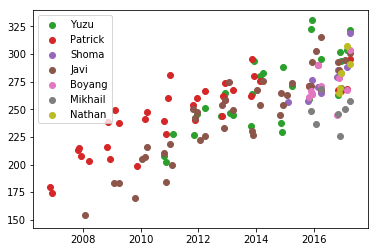

In [52]:
for data, name in ((hanyu, 'Yuzu'),
                   (patrick, 'Patrick'),
                   (shoma, 'Shoma'),
                   (javi, 'Javi'),
                   (boyang, 'Boyang'),
                   (mikhail, 'Mikhail'),
                   (nathan, 'Nathan')):
    plt.scatter(data['Date'].values, data['Points'].astype(float), label=name)
plt.legend()
plt.show()

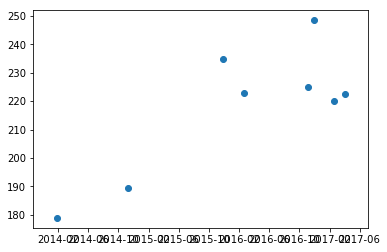

In [61]:
data = all_men_results[all_men_results['Name'] == 'Keiji TANAKA']
plt.scatter(data['Date'].values, data['Points'].astype(float), label=name)
plt.show()

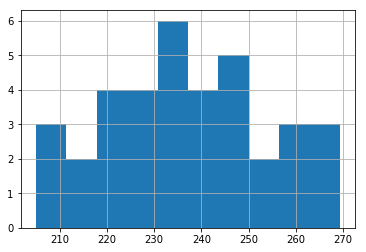

In [48]:
all_men_results[all_men_results.Name == 'Daisuke TAKAHASHI'].Points.astype(float).hist()
plt.show()

In [45]:
perfs = {}
for name in all_men_results.Name.unique():
    perfs[name] = len(all_men_results[all_men_results.Name == name])

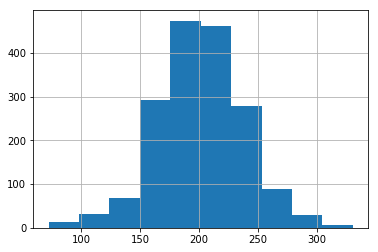

In [32]:
all_men_results[all_men_results['Free Rank'].str.isalpha() != True]['Points'].astype(float).hist()
plt.show()

In [33]:
# score = previous_median_result + skate order
ignore_wds = all_men_results[all_men_results.Points != 'WD']

In [34]:
ignore_wds = ignore_wds[ignore_wds.Event.map(
     lambda x: x not in [event.name for event in seasons['2017'].events])]

In [79]:
ind_men_results = {skater: np.median(map(float, ignore_wds[ignore_wds.Name == skater].Points))
                   for skater in ignore_wds.Name.get_values()}

In [80]:
np.median(ind_men_results.values())

160.56999999999999

In [37]:
results2017 = all_men_results[all_men_results.Points != 'WD']
results2017 = results2017[results2017.Event.map(lambda x: x in [event.name for event in seasons['2017'].events])]

In [81]:
def get_prev_score(row):
    if row.Name not in ind_men_results:
        return np.median(ind_men_results.values())
    return ind_men_results[row.Name]

In [82]:
results2017['median_score'] = results2017.apply(get_prev_score, axis=1)

In [40]:
# Need start order + either SP or FS score
# segment score = prev_median + start order

In [68]:
event_map = {event.name: event for event in seasons['2017'].events}

In [69]:
def get_start_order(row):
    return event_map[row.Event].disciplines[0].segments[0].scorecards[int(row.Rank)-1].starting_number

In [70]:
results2017['start_order'] = results2017.apply(get_start_order, axis=1)

In [78]:
results2017.head()

,Date,Event,Free Rank,Free Score,Name,Nation,Points,Rank,Short Rank,Short Score,median_score,start_order,max_score
0,2016-10-23,gpusa2016,1,190.19,Shoma UNO,JPN,279.34,1,1,89.15,276.79,9,276.79
1,2016-10-23,gpusa2016,2,182.63,Jason BROWN,USA,268.38,2,3,85.75,248.29,10,248.29
2,2016-10-23,gpusa2016,3,174.11,Adam RIPPON,USA,261.43,3,2,87.32,264.44,8,264.44
3,2016-10-23,gpusa2016,5,166.6,Sergei VORONOV,RUS,245.28,4,5,78.68,252.55,5,252.55
4,2016-10-23,gpusa2016,4,172.15,Boyang JIN,CHN,245.08,5,8,72.93,289.83,4,289.83


In [73]:
X = results2017[['max_score', 'start_order']].astype(float)
X = sm.add_constant(X)

In [74]:
y = results2017['Short Score'].astype(float)

In [75]:
mod = sm.OLS(y, X).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:            Short Score   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     118.3
Date:                Tue, 30 Jan 2018   Prob (F-statistic):           1.00e-32
Time:                        19:53:06   Log-Likelihood:                -621.52
No. Observations:                 170   AIC:                             1249.
Df Residuals:                     167   BIC:                             1258.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          29.4918      3.053      9.661      

In [84]:
mod = sm.OLS(y, results2017[['median_score', 'start_order']].astype(float)).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:            Short Score   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2863.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):          1.63e-130
Time:                        19:56:41   Log-Likelihood:                -675.61
No. Observations:                 170   AIC:                             1355.
Df Residuals:                     168   BIC:                             1362.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
median_score     0.3462      0.008     42.992   

In [87]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
print lr.coef_, lr.intercept_, lr.score(X, y)

[ 0.          0.18809471  0.29700585] 29.4918027933 0.586217487688


In [117]:
get_similar_names(pd.concat(ladies)['Name'].unique())

([('Elena SOKOLOVA', 'Elena GLEBOVA'),
  ('Elena SOKOLOVA', 'Alena LEONOVA'),
  ('Elena SOKOLOVA', 'Alina FJODOROVA'),
  ('Elena SOKOLOVA', 'Elena RADIONOVA'),
  ('Beatrisa LIANG', 'Teresa LIN'),
  ('Emily HUGHES', 'Emily NAPHTAL'),
  ('Mira LEUNG', 'Tina WANG'),
  ('Mira LEUNG', 'Mirna LIBRIC'),
  ('Mira LEUNG', 'Bingwa GENG'),
  ('Mira LEUNG', 'Ira VANNUT'),
  ('Mira LEUNG', 'Ying ZHANG'),
  ('Mira LEUNG', 'KIM Yuna'),
  ('Mira LEUNG', 'Rika HONGO'),
  ('Julia SEBESTYEN', 'Julia SHEREMET'),
  ('Julia SEBESTYEN', 'Julia SAUTER'),
  ('Dan FANG', 'Yan LIU'),
  ('Dan FANG', 'Mao ASADA'),
  ('Dan FANG', 'Na HOU'),
  ('Dan FANG', 'Mai ASADA'),
  ('Dan FANG', 'Diane CHEN'),
  ('Dan FANG', 'LIU Yan'),
  ('Dan FANG', 'Yueren WANG'),
  ('Dan FANG', 'Tina WANG'),
  ('Dan FANG', 'WANG Tina'),
  ('Dan FANG', 'Dasa GRM'),
  ('Dan FANG', 'Kexin ZHANG'),
  ('Dan FANG', 'Ying ZHANG'),
  ('Dan FANG', 'KIM Yuna'),
  ('Dan FANG', 'Angela WANG'),
  ('Dan FANG', 'Lu ZHENG'),
  ('Dan FANG', 'Amy LIN'),
  (

In [66]:
# Tried to cluster judges for wc2017 free dance. Don't see any bloc voting.
# seasons['2017'].events[-1].disciplines[-1].segments[-1].scorecards[0].print_scorecard()

In [48]:
judges = [[] for _ in xrange(9)]

In [49]:
for scorecard in seasons['2017'].events[-1].disciplines[-1].segments[-1].scorecards:
    for elt in scorecard.elements:
        for i, goe in enumerate(elt.goes):
            judges[i].append(goe)
    for comp in scorecard.components:
        for i, score in enumerate(comp.scores):
            judges[i].append(score)

In [60]:
from sklearn.cluster import KMeans

In [64]:
kmeans = KMeans(3).fit(np.array(judges))

In [65]:
kmeans.labels_

array([0, 1, 2, 1, 2, 0, 1, 1, 1], dtype=int32)

In [63]:
seasons['2017'].events[-1].disciplines[-1].segments[-1].panel

Official(function=u'Referee', name=u'Mr. Rolf PIPOH', nation=u'ISU')
Official(function=u'Technical Controller', name=u'Ms. Ludmila MIKHAILOVSKAYA', nation=u'ISU')
Official(function=u'Technical Specialist', name=u'Mr. Andrzej DOSTATNI', nation=u'ISU')
Official(function=u'Assistant Technical Specialist', name=u'Mr. Gy\xf6rgy ELEK', nation=u'ISU')
Official(function=u'Judge No.1', name=u'Ms. Marta OLOZAGARRE', nation=u'ISU')
Official(function=u'Judge No.2', name=u'Ms. Nicole LEBLANC-RICHARD', nation=u'ISU')
Official(function=u'Judge No.3', name=u'Ms. Sharon ROGERS', nation=u'ISU')
Official(function=u'Judge No.4', name=u'Ms. Chihee RHEE', nation=u'ISU')
Official(function=u'Judge No.5', name=u'Mr. Vladislav PETUKHOV', nation=u'ISU')
Official(function=u'Judge No.6', name=u'Mr. Christian BAUMANN', nation=u'ISU')
Official(function=u'Judge No.7', name=u'Mr. Garry HOPPE', nation=u'ISU')
Official(function=u'Judge No.8', name=u'Ms. Maira ABASOVA', nation=u'ISU')
Official(function=u'Judge No.9', nam

In [ ]:
Marta OLOZAGARRE    # SPA
Nicole LEBLANC-RICHARD   # CAN -
Sharon ROGERS       # USA --
Chihee RHEE         # KOR -
Vladislav PETUKHOV  # UKR --
Christian BAUMANN   # GER 
Garry HOPPE         # GBR -
Maira ABASOVA       # RUS -
Mr. Richard KOSINA  # CZE -